In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv')

In [3]:
del df['num_doors']
df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,12.488369


In [4]:
df = df.fillna(0)

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
df_full_train,df_test=train_test_split(df,test_size=0.2,random_state=1)
df_train,df_val = train_test_split(df_full_train,test_size=0.25,random_state=1)

In [7]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [8]:
y_train = df_train.fuel_efficiency_mpg.values
y_val = df_val.fuel_efficiency_mpg.values
y_test = df_test.fuel_efficiency_mpg.values

In [9]:
del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']


In [10]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mean_squared_error


now convert the dataframe into dictionaries

In [77]:
train_dicts = df_train.to_dict(orient='records')


In [12]:
dv=DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [13]:
dv.get_feature_names_out()

array(['acceleration', 'drivetrain=All-wheel drive',
       'drivetrain=Front-wheel drive', 'engine_displacement',
       'fuel_type=Diesel', 'fuel_type=Gasoline', 'horsepower',
       'model_year', 'num_cylinders', 'origin=Asia', 'origin=Europe',
       'origin=USA', 'vehicle_weight'], dtype=object)

In [21]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train,y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,1
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [78]:
val_dicts = df_val.to_dict(orient='records')


In [22]:
X_val = dv.transform(val_dicts)

In [18]:
from sklearn.tree import export_text

In [19]:
print(export_text(dt,feature_names=dv.get_feature_names_out()))

|--- vehicle_weight <= 3022.11
|   |--- value: [16.88]
|--- vehicle_weight >  3022.11
|   |--- value: [12.94]



## question 2 
train random forest and find rmse

In [25]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=10,random_state=1,n_jobs=-1)
rf.fit(X_train,y_train)

,n_estimators,10
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [27]:
y_pred = rf.predict(X_val)

In [28]:
mean_squared_error(y_pred,y_val)

0.21232989553299916

In [31]:
scores=[]
for n in range(10,200,10):
    rf = RandomForestRegressor(n_estimators=n,random_state=1)
    rf.fit(X_train,y_train)

    y_pred=rf.predict(X_val)
    auc= mean_squared_error(y_val,y_pred)    
    scores.append((n,auc))

In [32]:
df_scores = pd.DataFrame(scores,columns=['n_estimators','auc'])
df_scores

,n_estimators,auc
0,10,0.212330
1,20,0.205932
2,30,0.203859
3,40,0.201236
4,50,0.199685
5,60,0.198931
6,70,0.198456
7,80,0.198220
8,90,0.198295
9,100,0.198159


In [35]:
df_scores.sort_values('auc')

,n_estimators,auc
17,180,0.196005
18,190,0.196123
16,170,0.196378
15,160,0.196411
14,150,0.196739
13,140,0.197081
12,130,0.197290
10,110,0.197510
11,120,0.197530
9,100,0.198159


## here the 180th n_estimators has lowest rmsc 

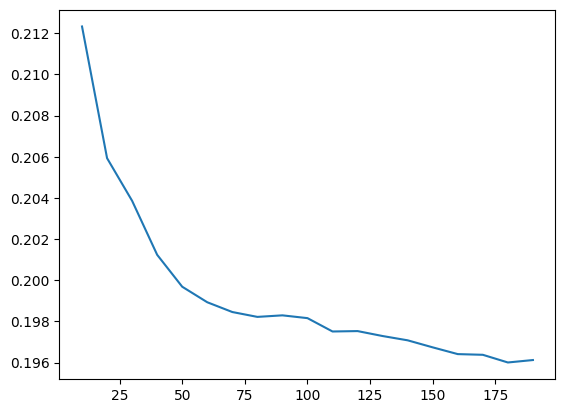

In [33]:
plt.plot(df_scores.n_estimators,df_scores.auc)

## now find the best max_depth

In [37]:
scores=[]
for d in [5,10,15,20,25]:
 for n in range(10,201,10):
    rf = RandomForestRegressor(n_estimators=n,max_depth=d,random_state=1,n_jobs=-1)
    rf.fit(X_train,y_train)

    y_pred=rf.predict(X_val)
    auc= mean_squared_error(y_val,y_pred)    
    scores.append((n,d,auc))

In [39]:
column=['n_estimators','max_depth','RMSE']
df_scores = pd.DataFrame(scores,columns=column)
df_scores.head()

,n_estimators,max_depth,RMSE
0,10,5,0.254822
1,20,5,0.253820
2,30,5,0.252565
3,40,5,0.251776
4,50,5,0.251583


In [79]:
df_scores.sort_values('RMSE').head()

,n_estimators,max_depth,RMSE
37,180,10,0.193298
39,200,10,0.193373
38,190,10,0.193412
35,160,10,0.193465
36,170,10,0.193492


## so the best max_depth is 10

In [41]:
rf = RandomForestRegressor(n_estimators=10,max_depth=20,random_state=1,n_jobs=-1)
rf.fit(X_train,y_train)

,n_estimators,10
,criterion,'squared_error'
,max_depth,20
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [47]:
rf.feature_importances_

array([1.17788447e-02, 3.36749448e-04, 4.05213902e-04, 3.45195688e-03,
       3.47667795e-04, 3.67703216e-04, 1.62642739e-02, 3.50031263e-03,
       2.53719850e-03, 4.78575907e-04, 5.56067031e-04, 5.39523961e-04,
       9.59435912e-01])

In [54]:
dv.get_feature_names_out()

array(['acceleration', 'drivetrain=All-wheel drive',
       'drivetrain=Front-wheel drive', 'engine_displacement',
       'fuel_type=Diesel', 'fuel_type=Gasoline', 'horsepower',
       'model_year', 'num_cylinders', 'origin=Asia', 'origin=Europe',
       'origin=USA', 'vehicle_weight'], dtype=object)

## vehicle_weinght is the most important feature

In [55]:
import xgboost as xgb

In [56]:
feature = dv.get_feature_names_out().tolist()
dtrain = xgb.DMatrix(X_train,label=y_train,feature_names=feature)
dval = xgb.DMatrix(X_val,label=y_val,feature_names=feature)


In [71]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params,dtrain,num_boost_round=10)

In [72]:
y_pred = model.predict(dval)

In [73]:
mean_squared_error(y_val,y_pred)

0.19895188197051858

In [74]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params,dtrain,num_boost_round=10)

In [75]:
y_pred = model.predict(dval)

In [76]:
mean_squared_error(y_val,y_pred)

1.0394787515689756

eta:0.3 is leads to best RMSE